In [4]:
%%capture

from sz_utils import data_handler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# check if gpu is available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

# collect the data
preictal, interictal = data_handler.make_patient_windows("chb01")

# make the labels
X = np.concatenate((preictal, interictal), axis=0)
y = np.concatenate((np.ones((preictal.shape[0], 1)), np.zeros((interictal.shape[0], 1))), axis=0)

# Shuffle the data
shuffle_indices = np.random.permutation(np.arange(X.shape[0]))
X = X[shuffle_indices]
y = y[shuffle_indices]

# Split the data into train and test
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# Split test data into validation and test
val_size = int(X_test.shape[0] * 0.5)
X_val = X_test[:val_size]
y_val = y_test[:val_size]
X_test = X_test[val_size:]
y_test = y_test[val_size:]

In [5]:

import numpy as np
import mlflow.tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,LSTM, Conv1D, Activation, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import AUC
import keras

In [6]:

# shapes
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, "X_val shape:", X_val.shape, "y_val shape:", y_val.shape, "X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (672, 1280, 22) y_train shape: (672, 1) X_val shape: (84, 1280, 22) y_val shape: (84, 1) X_test shape: (84, 1280, 22) y_test shape: (84, 1)


In [8]:
num_classes = 2 
input_shape_dataset = (X_train.shape[1], X_train.shape[2])
input_shape_dataset

def create_model_cnn_basic_1_layer(
    input_shape_dataset: tuple = input_shape_dataset,
    num_classes: int = num_classes,
    debug: bool = False,
    filters: int = 256,
    kernel_size: int = 3,
    pool_size: int = 2,
    dropout: float = 0.1,
    dense_size: int = 64,
    loss: str = "binary_crossentropy",
    optimizer: str = "adam",
    metrics: list = ["accuracy"],

) -> tf.keras.Model:

    """This function creates a basic convolutional neural network model with 2 convolutional layers, 2 dense layers and a softmax layer

    :param input_shape_dataset: shape of the input data
    :type input_shape_dataset: tuple
    :param num_classes: number of classes
    :type num_classes: int
    :return: return a model
    :rtype: tf.keras.Model
    """

    if debug:
        print("------------model summary---------------")
        print("input_shape_dataset", input_shape_dataset)
        print("num_classes", num_classes)

    input_shape_dataset: tuple
    
    model = Sequential()

    model.add(Conv1D(filters, kernel_size, input_shape=(input_shape_dataset)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [9]:
def create_model_mlp(
    input_shape_dataset: tuple = input_shape_dataset,
    num_classes: int = num_classes,
    debug: bool = False,
    hidden_units: int = 256,
    dropout: float = 0.1,
    loss: str = "binary_crossentropy",
    optimizer: str = "adam",
    metrics: list = ["accuracy"],
) -> tf.keras.Model:

    """This function creates a basic Multi-layer Perceptron (MLP) model with 1 hidden layer

    :param input_shape_dataset: shape of the input data
    :type input_shape_dataset: tuple
    :param num_classes: number of classes
    :type num_classes: int
    :return: return a model
    :rtype: tf.keras.Model
    """

    if debug:
        print("------------model summary---------------")
        print("input_shape_dataset", input_shape_dataset)
        print("num_classes", num_classes)

    model = Sequential()

    model.add(Flatten(input_shape=input_shape_dataset))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model


## test artifacts

In [26]:
from dataclasses import dataclass
import tensorflow as tf
import mlflow
from sklearn.model_selection import KFold
import itertools
from sklearn.metrics import confusion_matrix

class Experiment:
    experiment_name: str
    model_name: str
    model: tf.keras.Model
    dataset: tuple
    hyperparameters: dict
    metrics: dict
    n_splits: int
    kf_metrics: dict
    kf_models: list


    def __init__(self, experiment_name, model_name, model, dataset, hyperparameters, metrics, n_splits):
        self.experiment_name = experiment_name
        self.model_name = model_name
        self.model = model
        self.dataset = dataset
        self.hyperparameters = hyperparameters
        self.metrics = metrics      
        self.n_splits = n_splits
        self.kf_metrics = {}
        self.kf_models = []

    def fit(self):
        kf = KFold(n_splits=self.n_splits)
        fold = 0
        for train_index, val_index in kf.split(self.dataset[0]):
            fold += 1
            print(f"Training fold {fold}/{self.n_splits}")
            X_train_fold, y_train_fold = self.dataset[0][train_index], self.dataset[1][train_index]
            X_val_fold, y_val_fold = self.dataset[0][val_index], self.dataset[1][val_index]
            mlflow.tensorflow.autolog()
            history = self.model.fit(X_train_fold, y_train_fold,
                                     validation_data=(X_val_fold, y_val_fold),
                                     epochs=self.hyperparameters["epochs"],
                                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
            # Log metrics for this fold
            self.log_metrics(history, fold=fold)
            self.kf_models.append(self.model)
        mlflow.log_artifact(self._log_graphs(history), artifact_path='Artifacts')
        return history

    def set_experiment(self):
        mlflow.set_experiment(self.experiment_name)

    def log_params(self):
        mlflow.log_param("model_name", self.model_name)
        for key, value in self.hyperparameters.items():
            mlflow.log_param(key, value)

    def log_metrics(self, history, fold=None):
        for metric_name, metric_values in history.history.items():
            if metric_name not in self.kf_metrics:
                self.kf_metrics[metric_name] = []
            self.kf_metrics[metric_name].append(metric_values)
            for epoch, value in enumerate(metric_values):
                mlflow.log_metric(f"Fold_{fold}_{metric_name}", value, step=epoch)



    def _log_graphs(self, history, y_true=None, y_pred=None, artifact_path='graphs.png'):
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

        # Accuracy plot
        ax[0].plot(history.history['accuracy'], label='train')
        ax[0].plot(history.history['val_accuracy'], label='val')
        ax[0].set_title('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Accuracy')
        ax[0].legend()

        # Loss plot
        ax[1].plot(history.history['loss'], label='train')
        ax[1].plot(history.history['val_loss'], label='val')
        ax[1].set_title('Loss')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].legend()

        # Confusion matrix
        if y_true is not None and y_pred is not None:
            y_pred_classes = (y_pred > 0.5).astype(int)
            cm = confusion_matrix(y_true, y_pred_classes)
            classes = ['Class 0', 'Class 1'] 
            cmap=plt.cm.Blues
            ax[2].imshow(cm, interpolation='nearest', cmap=cmap)
            ax[2].set_title('Confusion Matrix')
            ax[2].set_xticks(range(len(classes)))
            ax[2].set_yticks(range(len(classes)))
            ax[2].set_xticklabels(classes, rotation=45)
            ax[2].set_yticklabels(classes)
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                ax[2].text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()

        # courve roc
        import sklearn.metrics as metrics
        from sklearn.metrics import roc_curve
        
        if y_true is not None and y_pred is not None:
            y_pred_classes = (y_pred > 0.5).astype(int)
            # cm = confusion_matrix(y_true, y_pred_classes)
            fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
            ax[3].plot(fpr, tpr, label='ROC curve')
            ax[3].plot([0, 1], [0, 1], 'k--')
            ax[3].set_xlabel('False Positive Rate')
            ax[3].set_ylabel('True Positive Rate')
            ax[3].set_title('ROC Curve')
            ax[3].legend(loc="lower right")



        # Save the plots to a file
        plt.tight_layout()
        plt.savefig(artifact_path)
        return artifact_path


In [27]:

def registrar_experiment(experiment: Experiment):
    with mlflow.start_run(nested=True):
        experiment.set_experiment()
        experiment.log_params()
        history = experiment.fit()
        y_pred = experiment.model.predict(X_test)
        y_true = y_test
        experiment.log_metrics(history)
        y_pred_classes = (y_pred > 0.5).astype(int)
        graph_path = experiment._log_graphs(history, y_true=y_true, y_pred=y_pred_classes)
        mlflow.log_artifact(graph_path, artifact_path='Artifacts')


Traceback (most recent call last):
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 279, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 372, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\utils\file_utils.py", line 182, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist."

Training fold 1/5
Epoch 1/10
17/17 [==============================] - 1s 37ms/step - loss: 752.7858 - accuracy: 0.5903 - val_loss: 282.0315 - val_accuracy: 0.6296
Epoch 2/10
17/17 [==============================] - 0s 19ms/step - loss: 55.5802 - accuracy: 0.9218 - val_loss: 56.7806 - val_accuracy: 0.8741
Epoch 3/10
17/17 [==============================] - 0s 19ms/step - loss: 7.1040 - accuracy: 0.9758 - val_loss: 30.7184 - val_accuracy: 0.9407
Epoch 4/10
17/17 [==============================] - 0s 19ms/step - loss: 3.1408 - accuracy: 0.9851 - val_loss: 10.5056 - val_accuracy: 0.9630
Epoch 5/10
17/17 [==============================] - 0s 19ms/step - loss: 4.9235e-30 - accuracy: 1.0000 - val_loss: 10.2938 - val_accuracy: 0.9630
Epoch 6/10
17/17 [==============================] - 0s 19ms/step - loss: 1.2822e-15 - accuracy: 1.0000 - val_loss: 10.2567 - val_accuracy: 0.9630
Epoch 7/10
17/17 [==============================] - 0s 18ms/step - loss: 7.1033e-12 - accuracy: 1.0000 - val_loss: 10.

2023/04/03 16:35:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='2b2ab30bfc154736be28cc8f51f2db90'. Attempted logging new value 'None'.


Training fold 2/5
Epoch 1/10
17/17 [==============================] - 0s 22ms/step - loss: 5.2677 - accuracy: 0.9870 - val_loss: 2.4788 - val_accuracy: 0.9852
Epoch 2/10
17/17 [==============================] - 0s 19ms/step - loss: 1.5847 - accuracy: 0.9907 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 0s 17ms/step - loss: 6.6956e-16 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
17/17 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 0s 17ms/step - loss: 1.9519e-35 - accuracy: 1.00

2023/04/03 16:35:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='2b2ab30bfc154736be28cc8f51f2db90'. Attempted logging new value 'None'.


Training fold 3/5
Epoch 1/10
17/17 [==============================] - 0s 22ms/step - loss: 0.7894 - accuracy: 0.9963 - val_loss: 0.6554 - val_accuracy: 0.9925
Epoch 2/10
17/17 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.4354 - val_accuracy: 0.9925
Epoch 3/10
17/17 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.3967 - val_accuracy: 0.9925
Epoch 4/10
17/17 [==============================] - 0s 19ms/step - loss: 3.6357e-36 - accuracy: 1.0000 - val_loss: 0.3900 - val_accuracy: 0.9925
Epoch 5/10
17/17 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.3890 - val_accuracy: 0.9925
Epoch 6/10
17/17 [==============================] - 0s 18ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 2.8110e-16 - val_accuracy: 1.0000
Epoch 7/10
17/17 [==============================] - 0s 20ms/step - loss: 0.0520 - accuracy: 0.9981 - val_loss: 0.000

2023/04/03 16:35:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='2b2ab30bfc154736be28cc8f51f2db90'. Attempted logging new value 'None'.


Training fold 4/5
Epoch 1/10
17/17 [==============================] - 0s 24ms/step - loss: 0.0597 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 0s 18ms/step - loss: 0.0312 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
17/17 [==============================] - 0s 17ms/step - loss: 1.9989e-15 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 18ms/step - loss: 0.0520 - accuracy: 0.9981 - val_loss: 0.1085 - val_accuracy: 0.9925
Epoch 5/10
17/17 [==============================] - 0s 17ms/step - loss: 0.1275 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 0s 18ms/step - loss: 4.3569e-23 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


2023/04/03 16:35:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='2b2ab30bfc154736be28cc8f51f2db90'. Attempted logging new value 'None'.


Training fold 5/5
Epoch 1/10
17/17 [==============================] - 0s 24ms/step - loss: 0.0316 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
17/17 [==============================] - 0s 17ms/step - loss: 1.5262 - accuracy: 0.9926 - val_loss: 4.2761 - val_accuracy: 0.9851
Epoch 3/10
17/17 [==============================] - 0s 17ms/step - loss: 2.8984 - accuracy: 0.9870 - val_loss: 0.3008 - val_accuracy: 0.9925
Epoch 4/10
17/17 [==============================] - 0s 18ms/step - loss: 2.3241 - accuracy: 0.9851 - val_loss: 1.7742 - val_accuracy: 0.9925
Epoch 5/10
17/17 [==============================] - 0s 17ms/step - loss: 2.9645 - accuracy: 0.9833 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
17/17 [==============================] - 0s 17ms/step - loss: 0.3306 - accuracy: 0.9963 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


2023/04/03 16:35:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='32' for run ID='2b2ab30bfc154736be28cc8f51f2db90'. Attempted logging new value 'None'.


3/3 [==============================] - 0s 4ms/step


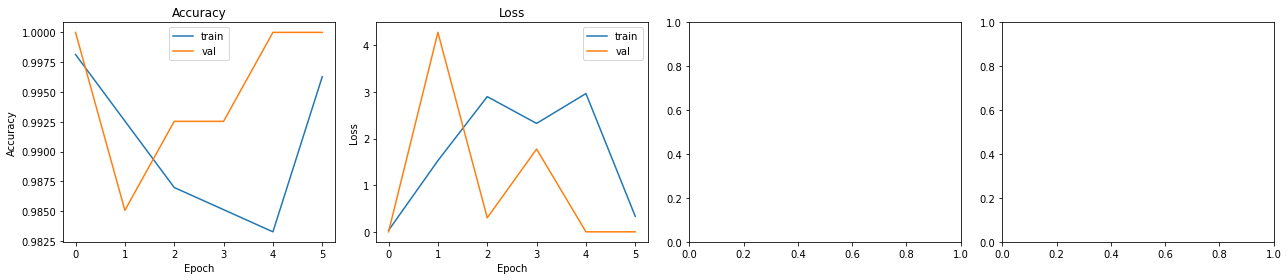

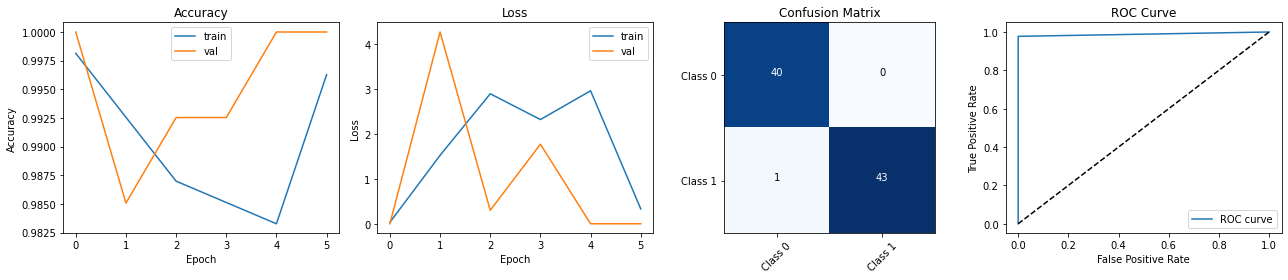

In [28]:
experiment_1 = Experiment(
    experiment_name = "CNN_autolog_experiment",
    model_name = "CNN_basic_1_layer",
    model = create_model_cnn_basic_1_layer(),
    dataset = (X_train, y_train, X_val, y_val),
    hyperparameters = {
        "epochs": 10,
        "filters": 256,
        "kernel_size": 3,
        "pool_size": 1,
        "dropout": 0.1,
        "dense_size": 32,
        "loss": "binary_crossentropy",
        "optimizer": "adam",
        "learning_rate": 0.001,
        "Dropout": 0.1,
        "batch_size": 32,
        "fold": 2,
        

    },metrics = ["accuracy"],

    n_splits = 2
)

registrar_experiment(experiment_1)

Traceback (most recent call last):
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 279, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 372, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\utils\file_utils.py", line 182, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist."

Training fold 1/5
Epoch 1/20
 5/17 [=======>......................] - ETA: 0s - loss: 169.9941 - accuracy: 0.5188

17/17 [==============================] - 1s 33ms/step - loss: 186.4729 - accuracy: 0.5642 - val_loss: 153.3854 - val_accuracy: 0.5852
Epoch 2/20
17/17 [==============================] - 0s 11ms/step - loss: 51.8899 - accuracy: 0.8436 - val_loss: 127.8340 - val_accuracy: 0.6444
Epoch 3/20
17/17 [==============================] - 0s 10ms/step - loss: 8.4896 - accuracy: 0.9292 - val_loss: 130.5308 - val_accuracy: 0.6741
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 4.8080 - accuracy: 0.9590 - val_loss: 129.0753 - val_accuracy: 0.6963
Epoch 5/20
17/17 [==============================] - 0s 10ms/step - loss: 0.2173 - accuracy: 0.9926 - val_loss: 140.6706 - val_accuracy: 0.7185
Epoch 6/20
17/17 [==============================] - 0s 10ms/step - loss: 0.5572 - accuracy: 0.9888 - val_loss: 137.0590 - val_accuracy: 0.7259
Epoch 7/20
1/1 [==============================] - 0s 39ms/step


2023/04/03 13:15:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmp1f63qk2q\model\data\model\assets


Training fold 2/5
Epoch 1/20
17/17 [==============================] - 0s 15ms/step - loss: 42.4735 - accuracy: 0.8585 - val_loss: 52.5314 - val_accuracy: 0.8593
Epoch 2/20
17/17 [==============================] - 0s 12ms/step - loss: 16.1686 - accuracy: 0.9236 - val_loss: 42.6055 - val_accuracy: 0.8815
Epoch 3/20
17/17 [==============================] - 0s 14ms/step - loss: 4.9799 - accuracy: 0.9609 - val_loss: 41.4583 - val_accuracy: 0.8815
Epoch 4/20
17/17 [==============================] - 0s 11ms/step - loss: 6.2458 - accuracy: 0.9721 - val_loss: 34.8602 - val_accuracy: 0.8815
Epoch 5/20
17/17 [==============================] - 0s 10ms/step - loss: 1.2340 - accuracy: 0.9851 - val_loss: 41.4509 - val_accuracy: 0.8815
Epoch 6/20
17/17 [==============================] - 0s 10ms/step - loss: 1.1637 - accuracy: 0.9814 - val_loss: 44.0198 - val_accuracy: 0.8889
Epoch 7/20
17/17 [==============================] - 0s 10ms/step - loss: 0.3085 - accuracy: 0.9907 - val_loss: 47.1264 - val_acc

2023/04/03 13:15:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpp7ju94eg\model\data\model\assets


Training fold 3/5
Epoch 1/20
17/17 [==============================] - 0s 16ms/step - loss: 9.7867 - accuracy: 0.9535 - val_loss: 1.3245 - val_accuracy: 0.9776
Epoch 2/20
17/17 [==============================] - 0s 11ms/step - loss: 4.1531 - accuracy: 0.9740 - val_loss: 1.2276 - val_accuracy: 0.9776
Epoch 3/20
17/17 [==============================] - 0s 11ms/step - loss: 3.0946 - accuracy: 0.9740 - val_loss: 1.8683 - val_accuracy: 0.9776
Epoch 4/20
17/17 [==============================] - 0s 11ms/step - loss: 1.9646 - accuracy: 0.9888 - val_loss: 9.1789 - val_accuracy: 0.9627
Epoch 5/20
17/17 [==============================] - 0s 11ms/step - loss: 2.4687 - accuracy: 0.9796 - val_loss: 9.2968 - val_accuracy: 0.9627
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 0.7209 - accuracy: 0.9870 - val_loss: 8.1810 - val_accuracy: 0.9627
Epoch 7/20
1/1 [==============================] - 0s 18ms/step


2023/04/03 13:15:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpfsme3vec\model\data\model\assets


Training fold 4/5
Epoch 1/20
17/17 [==============================] - 0s 16ms/step - loss: 1.5674 - accuracy: 0.9851 - val_loss: 2.1793 - val_accuracy: 0.9776
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 2.3869 - accuracy: 0.9833 - val_loss: 3.6052 - val_accuracy: 0.9552
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 1.1013 - accuracy: 0.9926 - val_loss: 3.9404 - val_accuracy: 0.9701
Epoch 4/20
17/17 [==============================] - 0s 10ms/step - loss: 2.0081 - accuracy: 0.9944 - val_loss: 9.0080 - val_accuracy: 0.9701
Epoch 5/20
17/17 [==============================] - 0s 10ms/step - loss: 1.6924 - accuracy: 0.9851 - val_loss: 4.8061 - val_accuracy: 0.9701
Epoch 6/20
1/1 [==============================] - 0s 19ms/step


2023/04/03 13:15:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmpxninfi08\model\data\model\assets


Training fold 5/5
Epoch 1/20
 1/17 [>.............................] - ETA: 0s - loss: 0.1182 - accuracy: 0.9688

17/17 [==============================] - 0s 16ms/step - loss: 1.3417 - accuracy: 0.9907 - val_loss: 3.3838 - val_accuracy: 0.9701
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 0.7930 - accuracy: 0.9907 - val_loss: 3.7853 - val_accuracy: 0.9627
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 1.6942 - accuracy: 0.9870 - val_loss: 3.9638 - val_accuracy: 0.9552
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 2.1734 - accuracy: 0.9851 - val_loss: 4.1759 - val_accuracy: 0.9478
Epoch 5/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6560 - accuracy: 0.9833 - val_loss: 3.5968 - val_accuracy: 0.9701
Epoch 6/20
1/1 [==============================] - 0s 21ms/step


2023/04/03 13:16:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\crist\AppData\Roaming\Python\Python39\site-packages\mlflow\tensorflow\__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."
INFO:tensorflow:Assets written to: C:\Users\crist\AppData\Local\Temp\tmp1rb09y4g\model\data\model\assets


3/3 [==============================] - 0s 3ms/step


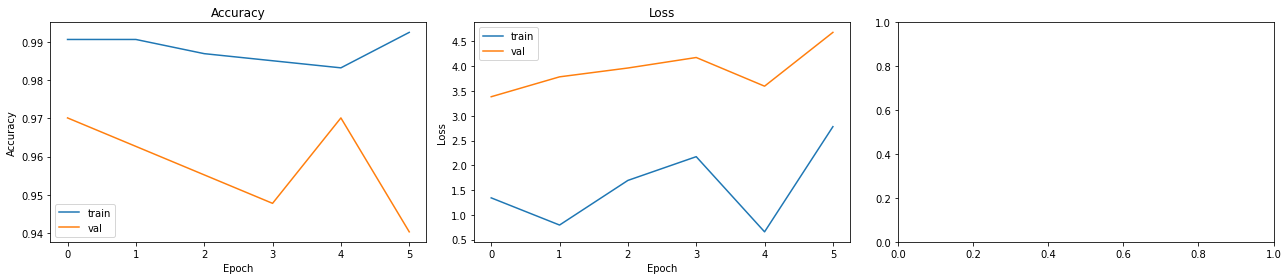

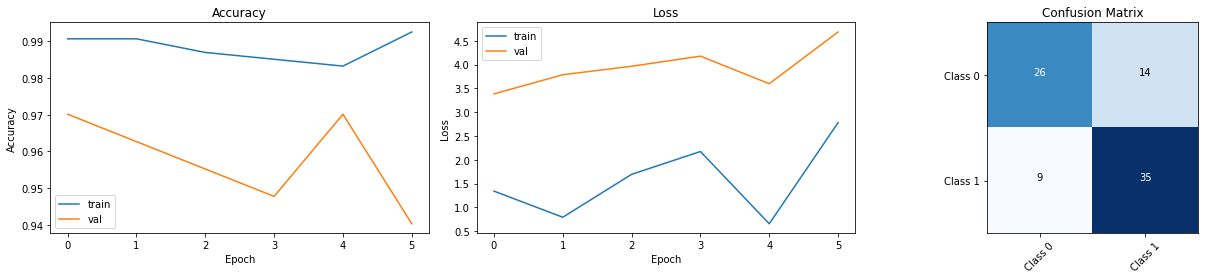

In [16]:
experiment_mlp = Experiment(
    experiment_name = "MLP_autolog_exp",
    model_name = "MLP_basic_1_layer",
    model = create_model_mlp(),
    dataset = (X_train, y_train, X_val, y_val),
    hyperparameters = {
        "epochs": 20,
        
        },
        metrics = ["accuracy"], n_splits = 5)

registrar_experiment(experiment_mlp)

In [29]:
# count values in list y_train y y_val
y_train

unique_values, counts = np.unique(y_train, return_counts=True)

print(unique_values)
print(counts)

[0. 1.]
[340 332]


In [30]:
unique_values, counts = np.unique(y_val, return_counts=True)

print(unique_values)
print(counts)

[0. 1.]
[40 44]
